# Probability of Failure Estimation with Gaussian Processes

In [1]:
!pip install botorch -U

In [2]:
import qmcpy as qp
import gpytorch
import torch
import os
import warnings
import pandas as pd
from gpytorch.utils.warnings import NumericalWarning
warnings.filterwarnings("ignore")
pd.set_option(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', 1000,
    'display.colheader_justify', 'center',
    'display.precision',2,
    'display.float_format',lambda x:'%.1e'%x)
from matplotlib import pyplot
pyplot.style.use("../qmcpy/qmcpy.mplstyle")

## 

In [3]:
!pip install botorch -U --quiet

In [4]:
import qmcpy as qp 
import pandas as pd 
pd.set_option(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', 1000,
    'display.colheader_justify', 'center',
    'display.precision',2,
    'display.float_format',lambda x:'%.1e'%x)
from matplotlib import pyplot
pyplot.style.use("../qmcpy/qmcpy.mplstyle")

In [5]:
gpytorch_use_gpu = torch.cuda.is_available()
gpytorch_use_gpu

False

## Sin 1d Problem

reference approximation with d=1: 0.5000002384185791
batch 0
	gpytorch model fitting
		iter 50  of 100
			likelihood.noise_covar.raw_noise.................. -8.63e-02
			covar_module.raw_outputscale...................... -3.04e+00
			covar_module.base_kernel.raw_lengthscale.......... 5.04e+00
		iter 100 of 100
			likelihood.noise_covar.raw_noise.................. -1.01e-01
			covar_module.raw_outputscale...................... -2.96e+00
			covar_module.base_kernel.raw_lengthscale.......... 6.29e+00
batch 1
	AR sampling with efficiency 2.6e-01, expect 15 draws: 12, 15, 18, 21, 24, 
batch 2
	AR sampling with efficiency 1.7e-01, expect 23 draws: 16, 20, 
batch 3
	AR sampling with efficiency 1.3e-01, expect 30 draws: 20, 25, 
batch 4
	AR sampling with efficiency 6.1e-02, expect 65 draws: 48, 72, 
PFGPCIData (AccumulateData Object)
    solution        0.500
    error_bound     0.073
    bound_low       0.426
    bound_high      0.573
    n_total         20
    time_integrate  0.644
PFGPCI (S

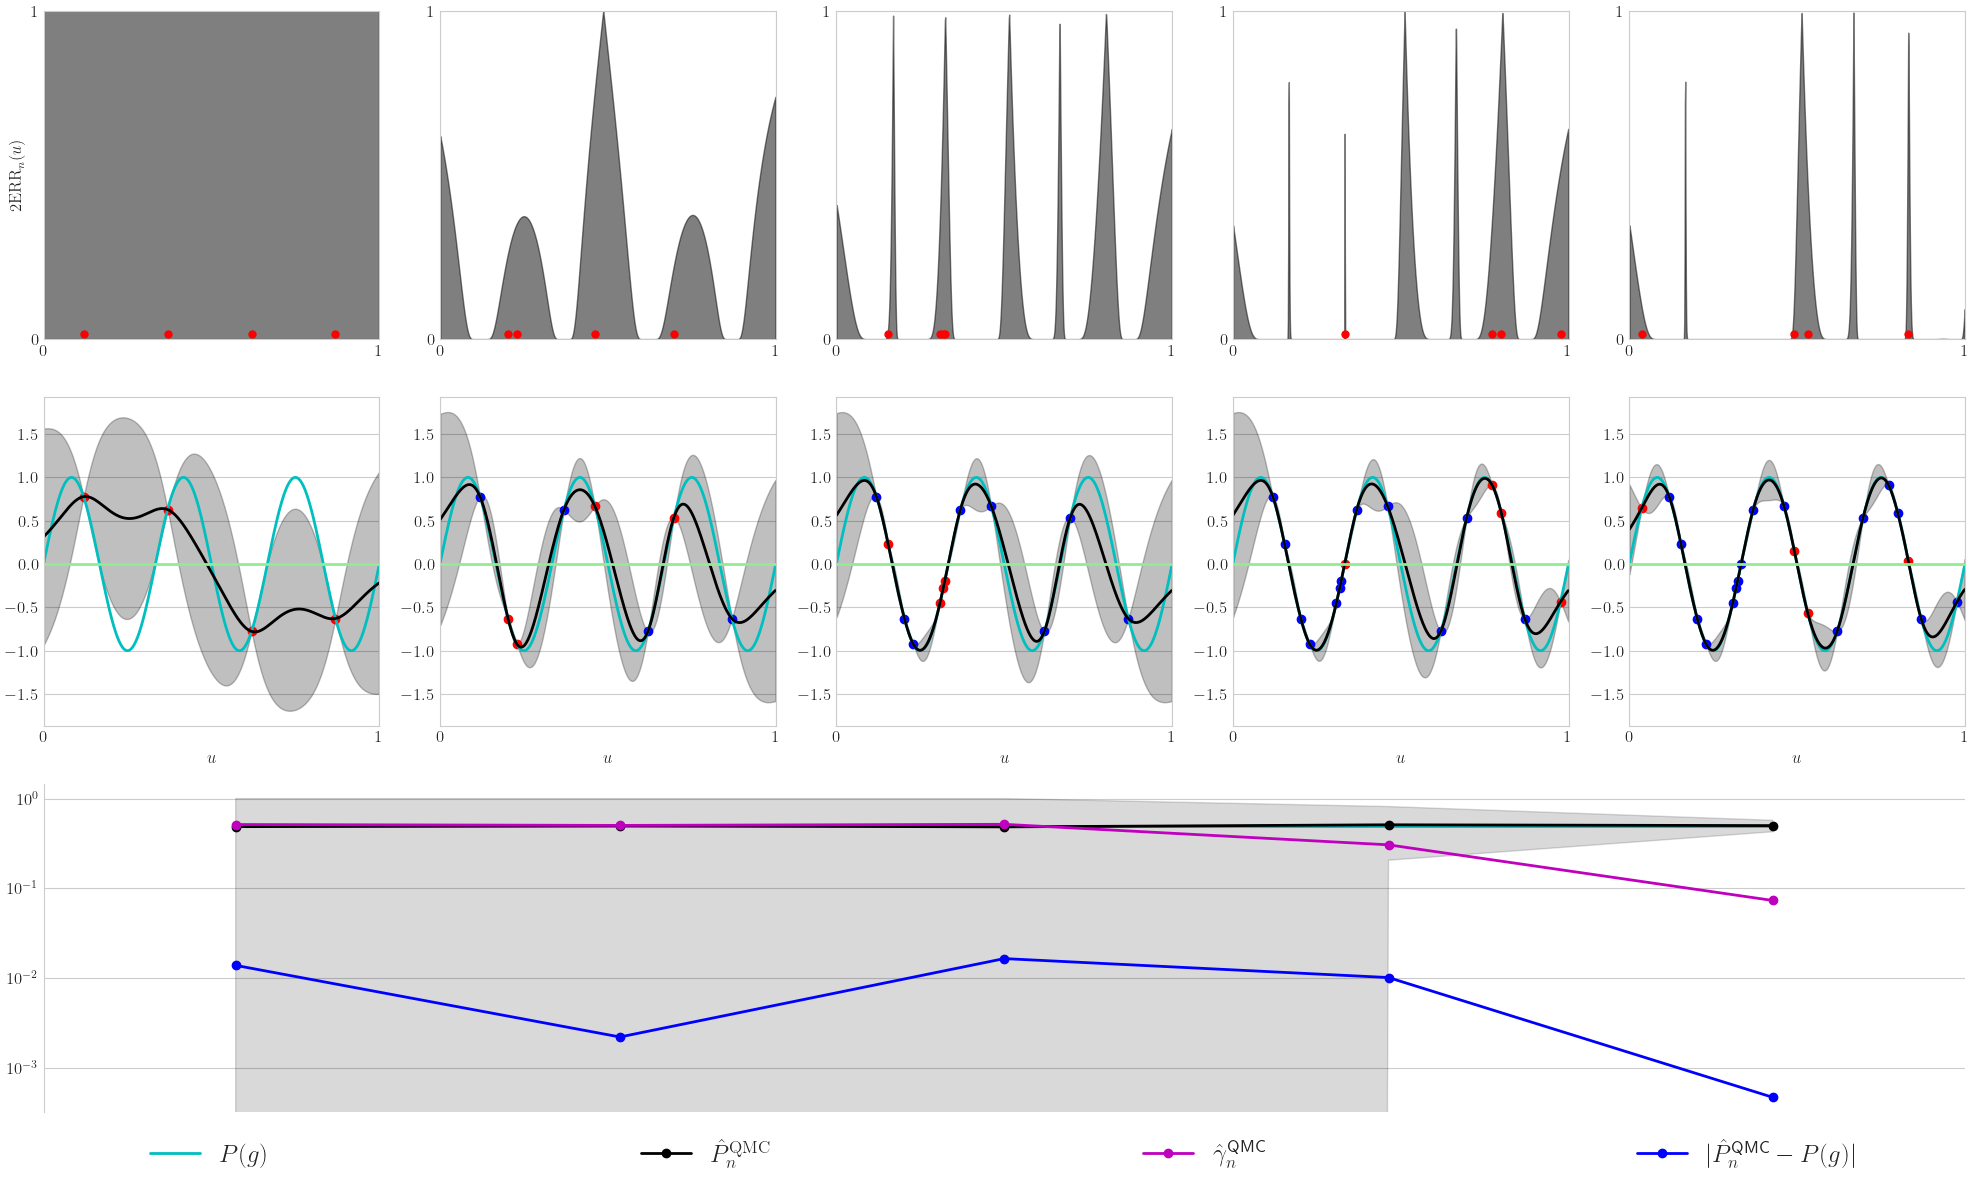

In [6]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Sin1d(qp.DigitalNetB2(1,seed=17),k=3),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 4,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 4,
    n_max = 20,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=2.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.01,.1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-3,10)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 100,
    gpytorch_use_gpu = False,
    verbose = 50,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
data.plot();

## Multimodal 2d Problem

reference approximation with d=2: 0.3020772933959961
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 1.45e+00
			covar_module.raw_outputscale...................... 2.92e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.02e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 1.49e+00
			covar_module.raw_outputscale...................... 3.70e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.32e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 1.53e+00
			covar_module.raw_outputscale...................... 4.24e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.43e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 1.58e+00
			covar_module.raw_outputscale...................... 4.66e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.48e+00
batch 1
	AR sampling with efficiency 7.6e-02, expect 211 draws: 144, 198, 
batch 2


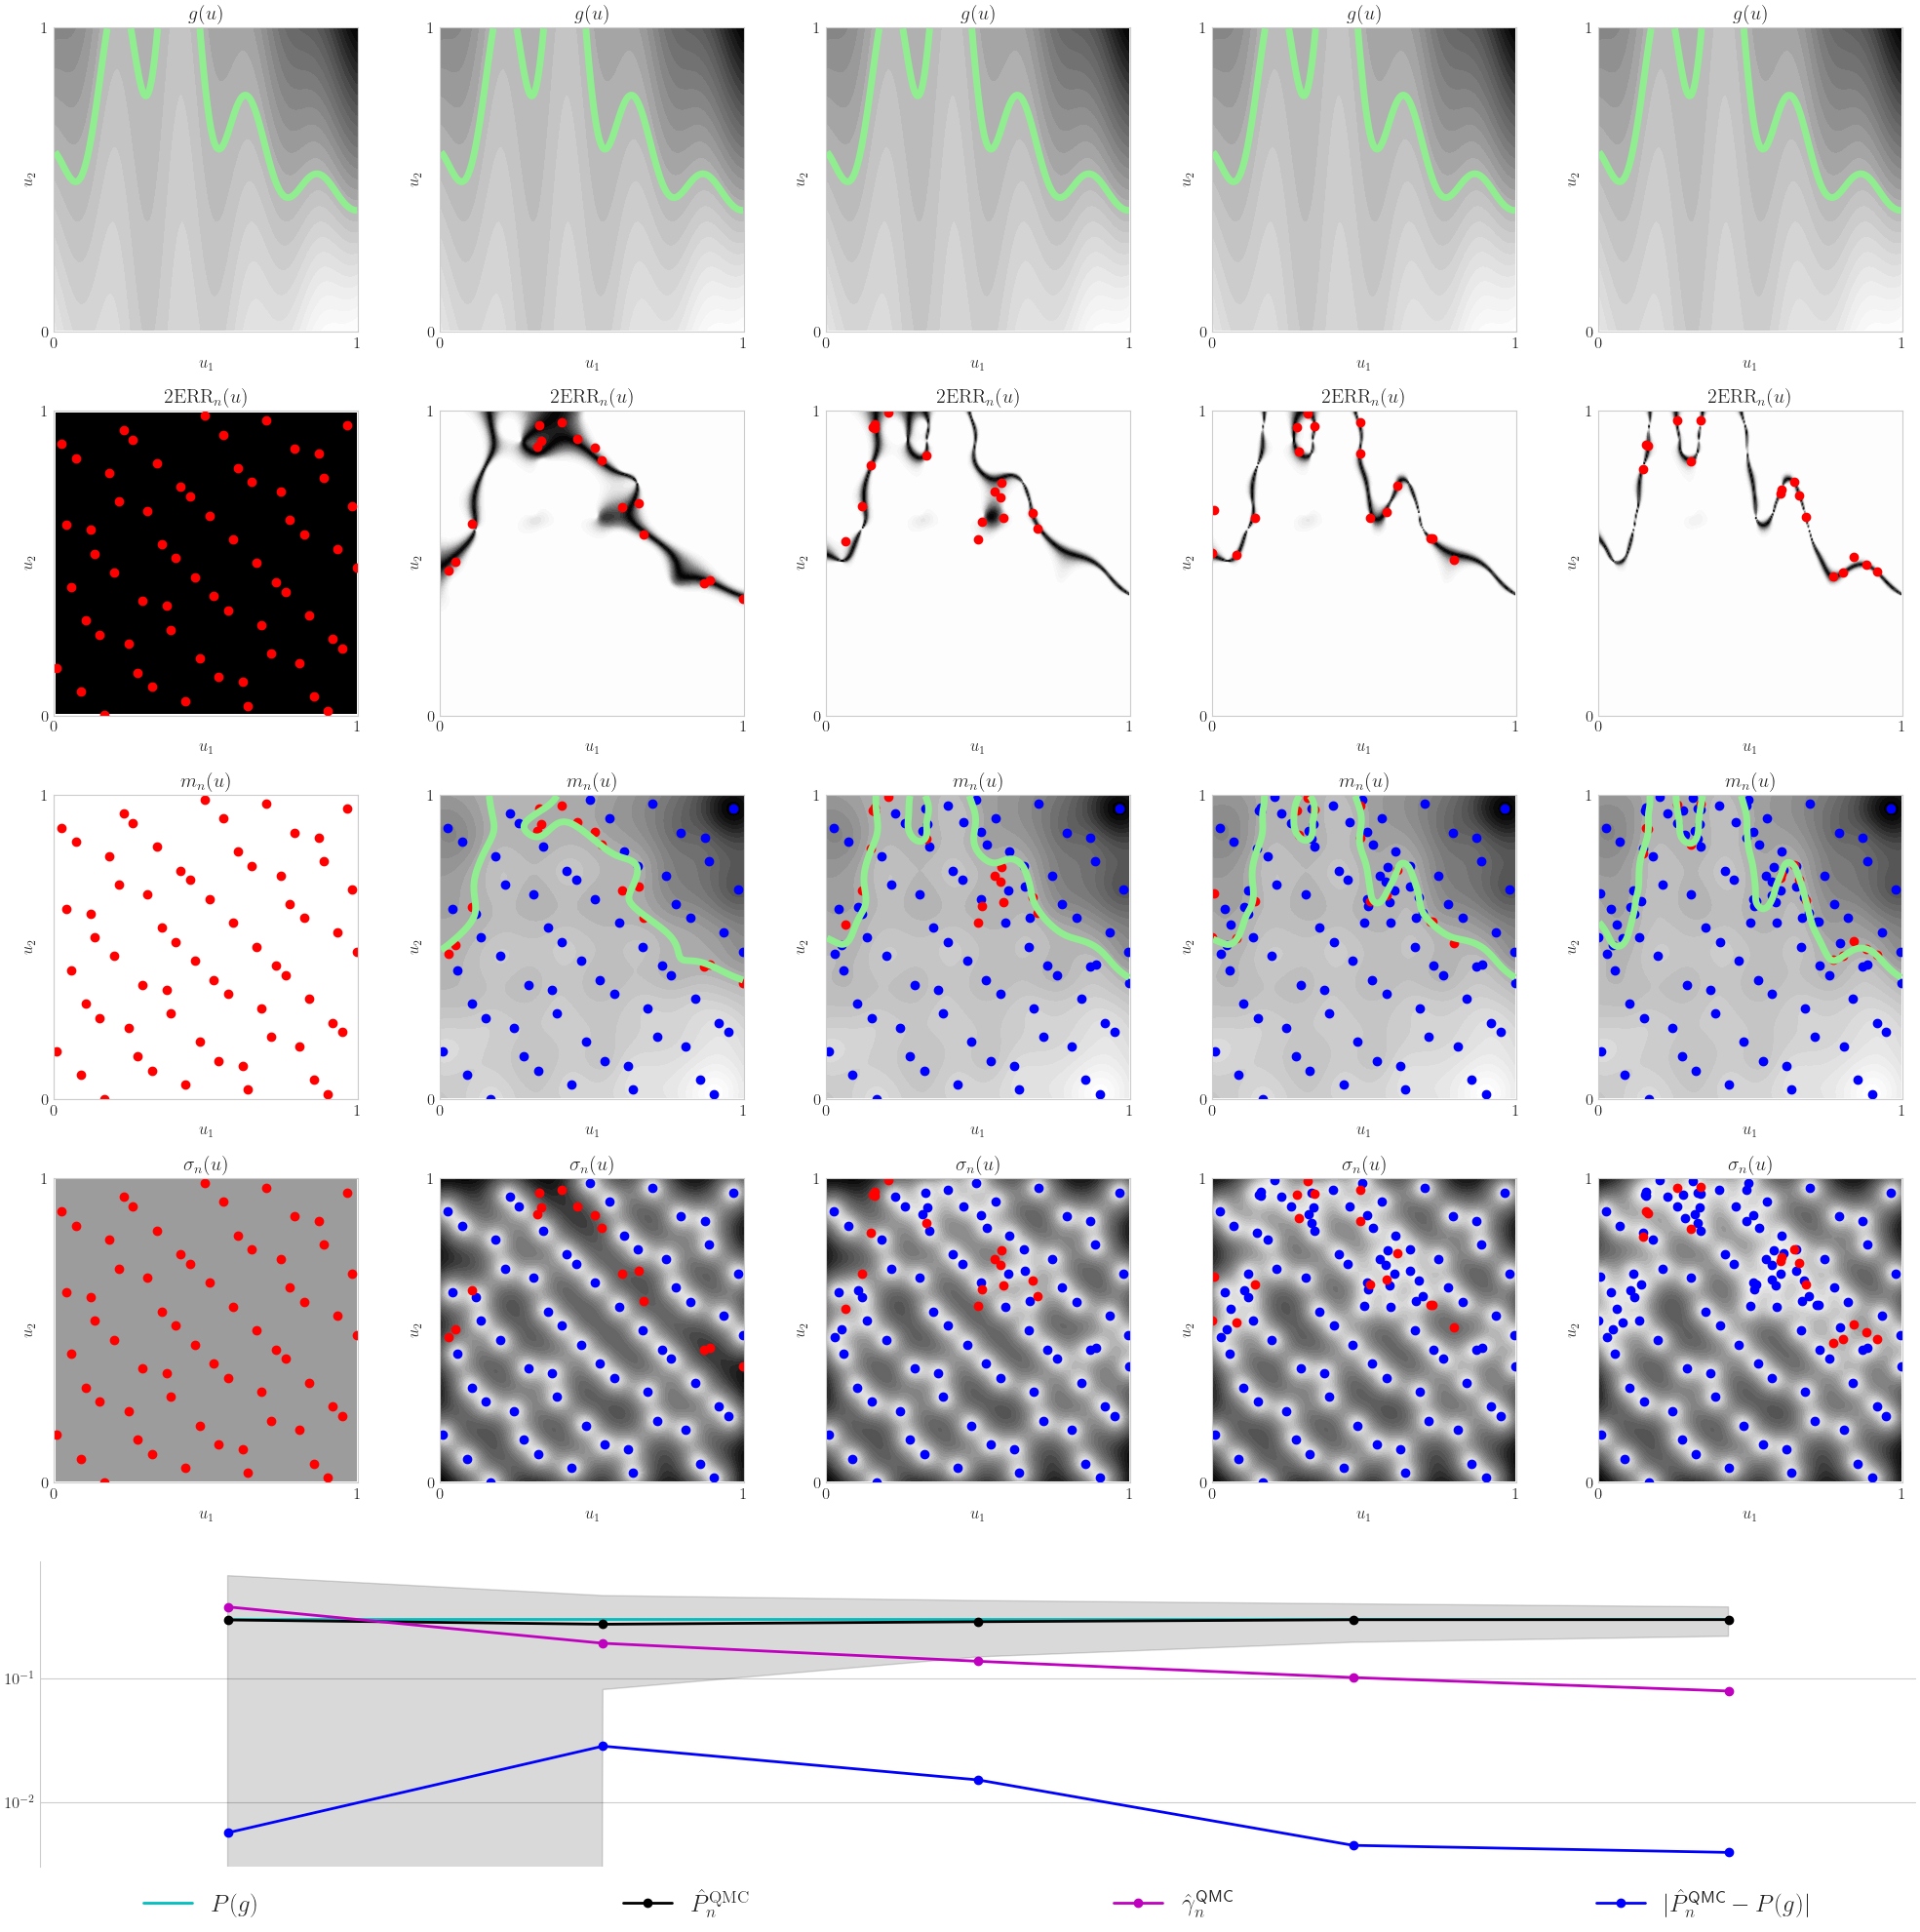

In [7]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Multimodal2d(qp.DigitalNetB2(2,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 64,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 16,
    n_max = 128,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=1.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.1,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-3,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
data.plot();

## Four Branch 2d Problem

reference approximation with d=2: 0.20872807502746582
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 2.89e+00
			covar_module.raw_outputscale...................... 3.88e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.50e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 3.63e+00
			covar_module.raw_outputscale...................... 4.78e+00
			covar_module.base_kernel.raw_lengthscale.......... -5.44e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 4.17e+00
			covar_module.raw_outputscale...................... 5.36e+00
			covar_module.base_kernel.raw_lengthscale.......... -6.04e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 4.59e+00
			covar_module.raw_outputscale...................... 5.80e+00
			covar_module.base_kernel.raw_lengthscale.......... -6.48e+00
batch 1
	AR sampling with efficiency 9.0e-03, expect 1337 draws: 924, 1232, 
batch

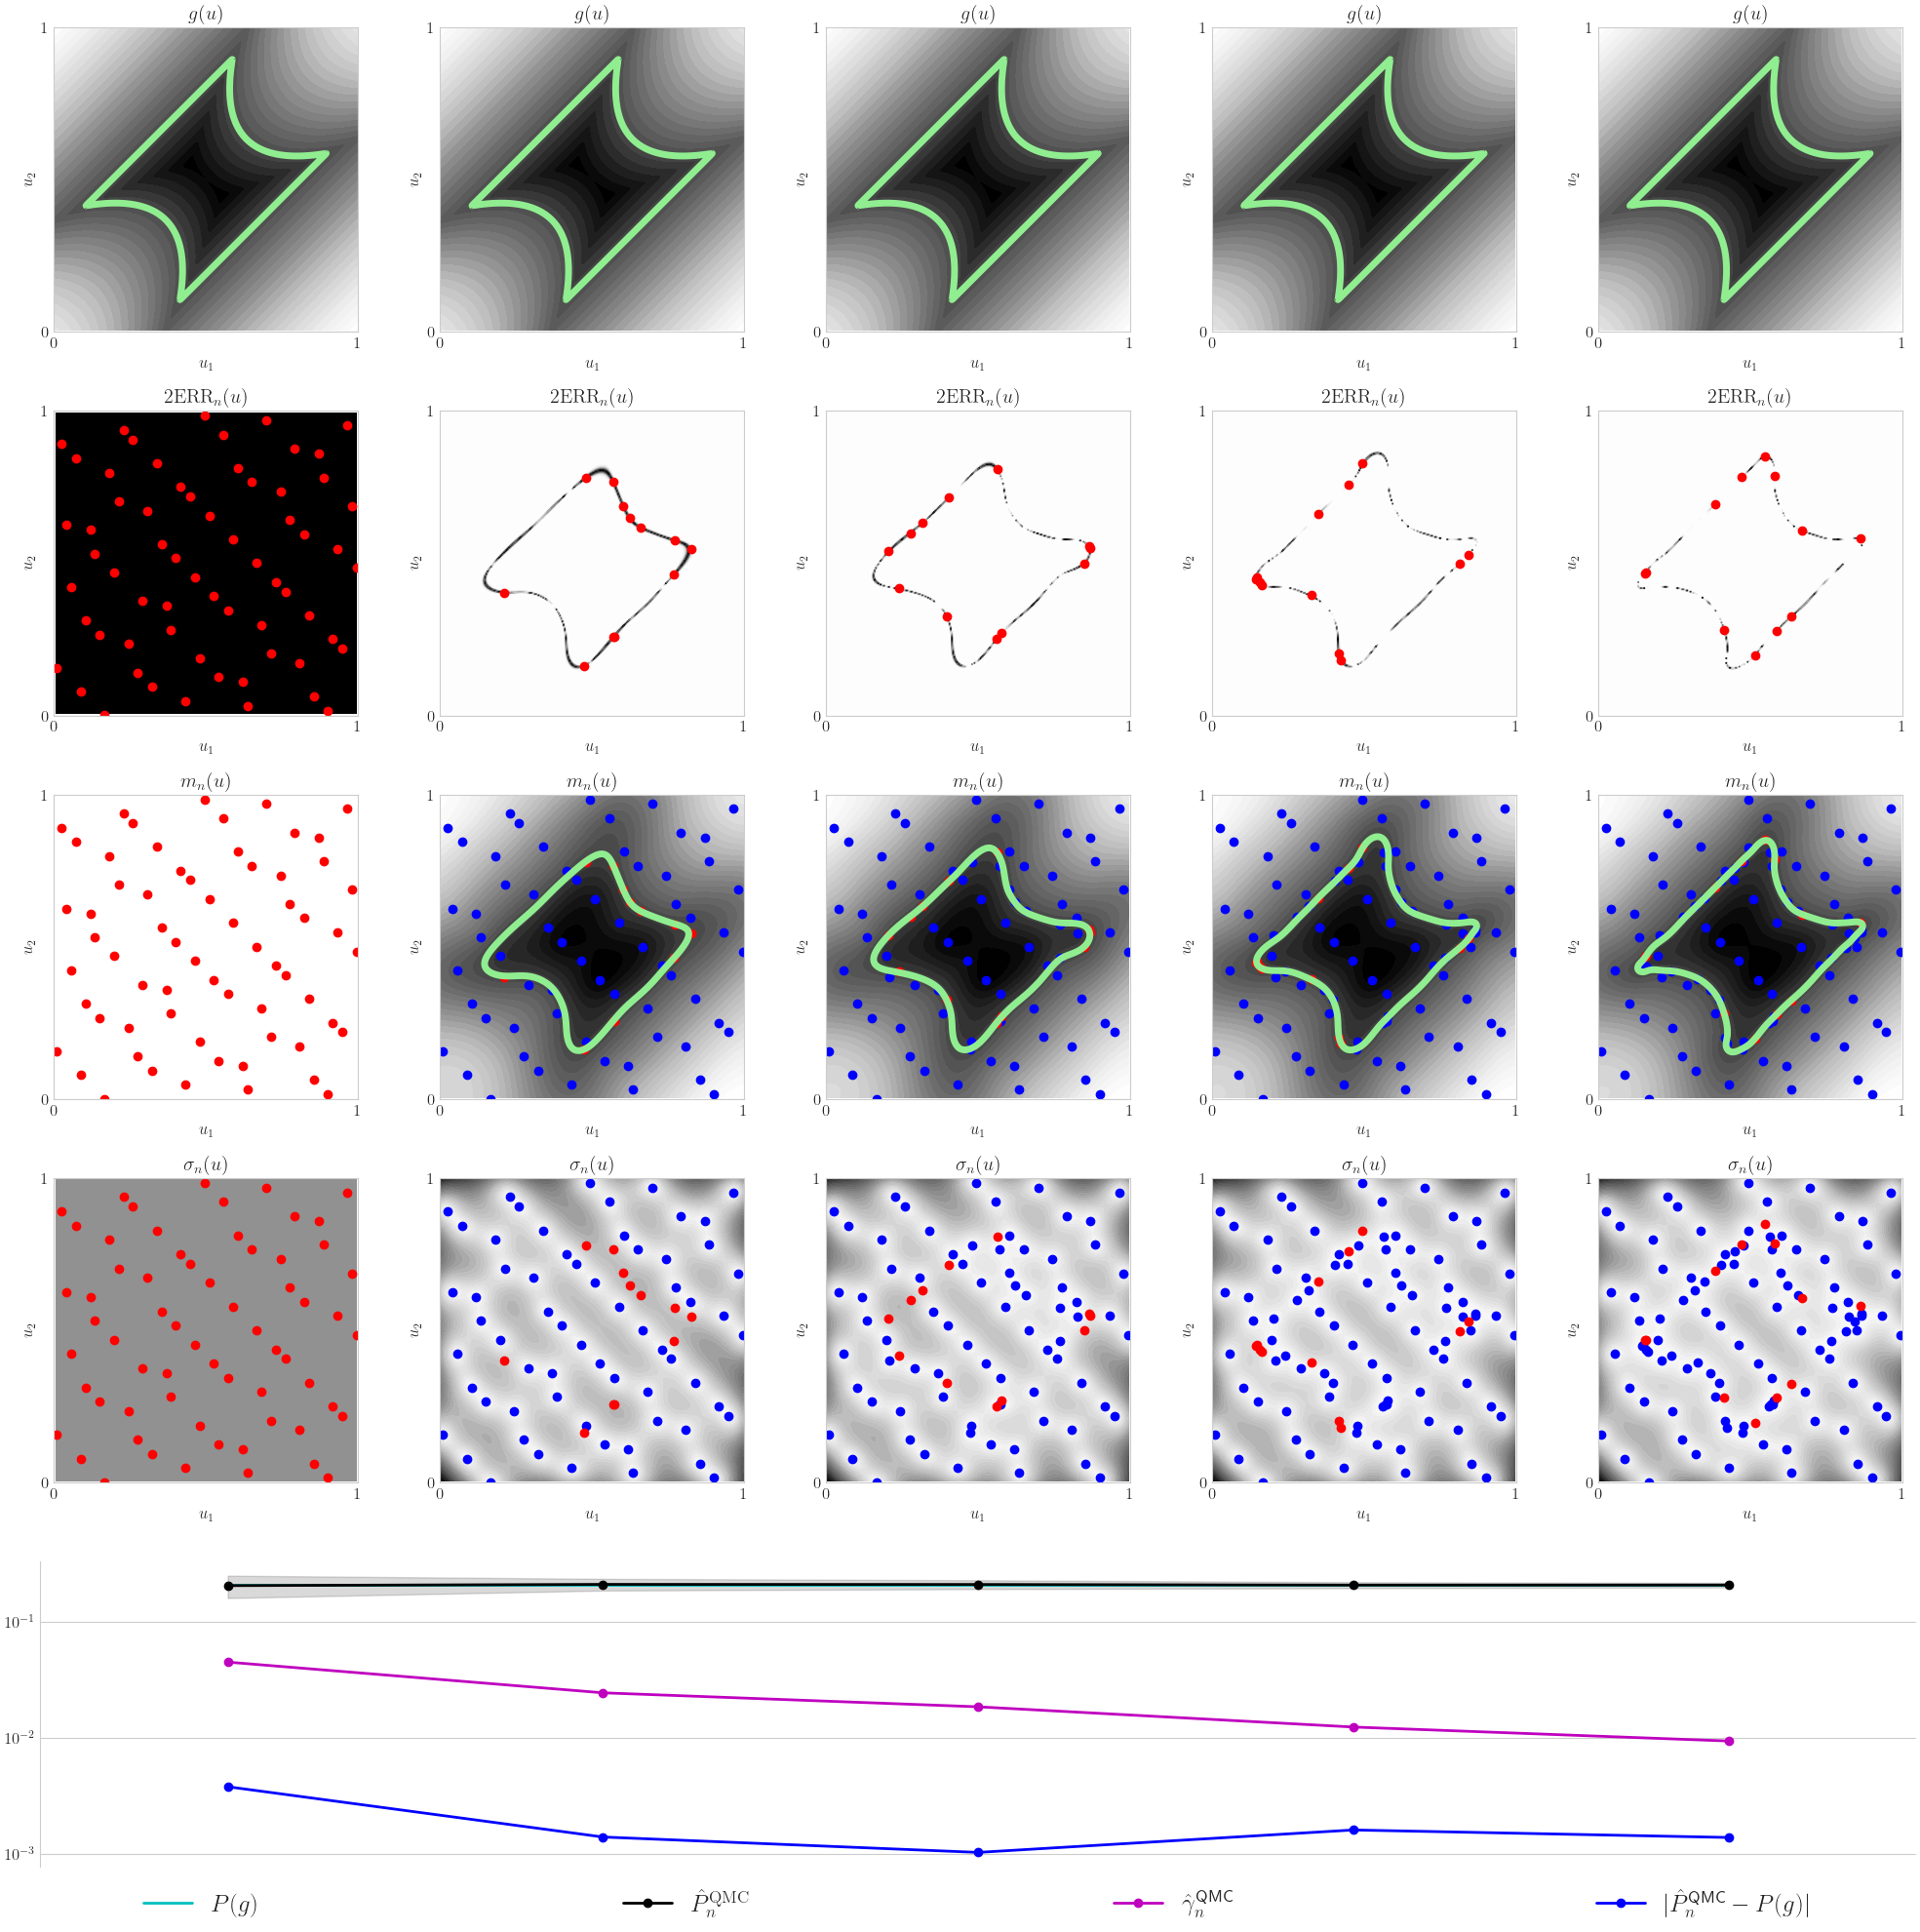

In [8]:
mcispfgp = qp.PFGPCI(
    integrand = qp.FourBranch2d(qp.DigitalNetB2(2,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 64,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 12,
    n_max = 200,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=1.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.5,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-8,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
data.plot();

## Ishigami 3d Problem

reference approximation with d=3: 0.16239547729492188
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 2.18e+00
			covar_module.raw_outputscale...................... 3.43e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.09e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 2.66e+00
			covar_module.raw_outputscale...................... 4.26e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.99e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 3.08e+00
			covar_module.raw_outputscale...................... 4.81e+00
			covar_module.base_kernel.raw_lengthscale.......... -5.56e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 3.43e+00
			covar_module.raw_outputscale...................... 5.24e+00
			covar_module.base_kernel.raw_lengthscale.......... -6.00e+00
batch 1
	AR sampling with efficiency 6.1e-03, expect 2626 draws: 1824, 
batch 2
	A

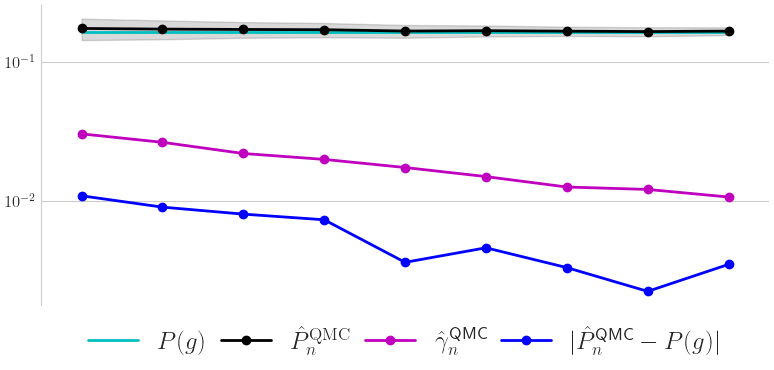

In [9]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Ishigami(qp.DigitalNetB2(3,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=False,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 128,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 16,
    n_max = 256,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=2.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.5,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-8,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
data.plot();

## Hartmann 6d Problem

reference approximation with d=6: 0.007387995719909668
batch 0
	gpytorch model fitting
		iter 50  of 150
			likelihood.noise_covar.raw_noise.................. 1.65e+00
			covar_module.raw_outputscale...................... 5.53e-01
			covar_module.base_kernel.raw_lengthscale.......... 2.79e-01
		iter 100 of 150
			likelihood.noise_covar.raw_noise.................. 2.80e+00
			covar_module.raw_outputscale...................... 5.10e-01
			covar_module.base_kernel.raw_lengthscale.......... 2.67e-01
		iter 150 of 150
			likelihood.noise_covar.raw_noise.................. 3.38e+00
			covar_module.raw_outputscale...................... 5.14e-01
			covar_module.base_kernel.raw_lengthscale.......... 2.68e-01
batch 1
	AR sampling with efficiency 1.4e-03, expect 45089 draws: 31232, 35624, 
batch 2
	AR sampling with efficiency 2.1e-03, expect 30750 draws: 21312, 27306, 29304, 30969, 31635, 32301, 
batch 3
	AR sampling with efficiency 1.8e-03, expect 35103 draws: 24320, 32680, 36860, 38000, 
batch 4

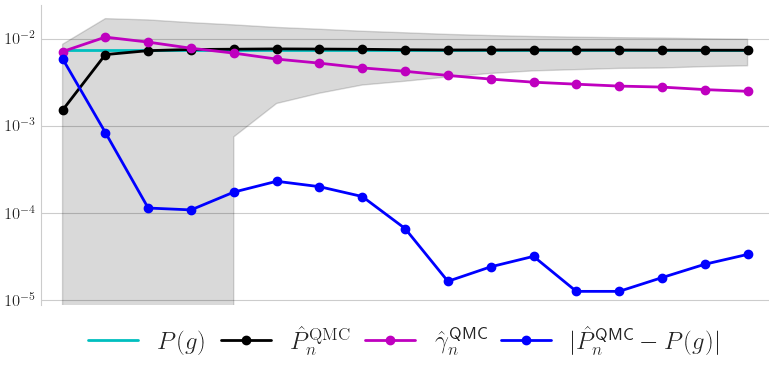

In [13]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Hartmann6d(qp.DigitalNetB2(6,seed=17)),
    failure_threshold = -2,
    failure_above_threshold=False,
    abs_tol = 2.5e-3,
    alpha = 1e-1,
    n_init = 512,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 64,
    n_max = 2500,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 150,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 50,
    n_ref_approx = 2**23,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
data.plot();